# Applied Economic Analysis: Python Assignment

|Name|ANR|
|----|-------|
|Joost Bouten|132978|
|Twan Vissers|495770|

# Exploring the world of cryptocurrencies

## Questions

- Out of the ten most valuable cryptocurrencies, which would be the best investment according to the [Sharpe ratio](https://web.stanford.edu/~wfsharpe/art/sr/sr.htm)? 
- Within the market for cryptocurrencies, what is the relation between average returns and volatility of prices?
- What would a machine learning algorithm predict for the price of a cryptocurrency, given that it only bases its prediction on historical price data? 

### Motivation

Cryptocurrencies are a hot topic. Since the hype around Bitcoin started, many entrepreneurs have taken a shot at developing their own coin or other product based on the blockchain technology. 

Being somewhat skeptical about the underlying value of cryptocurrencies, we aim to demonstrate effect of the incredible volatility that this market faces. By analyzing historical price data we hope to gain further insight in this market, as it still seems fuzzy to many people. 

### Method

1. We will start of by importing the data, and performing some graphical as well as numerical exploratory data analysis. 
2. Secondly, we will go on to some investment analysis, where we try to distinguish the best investment pick out of the three most valueable cryptocurrencies using the Sharpe ratio as our metric and the S&P 500 as our benchmark. 
3. Thirdly, we like to get insight into the relation between volatility and return within the cryptocurrency market by plotting a regression line through datapoints for hundreds of cryptocurrencies. We will try to provide further insight into these datapoints by making an interactive plot using the Bokeh package. 
4. Lastly, we will naively try to estimate future cryptocurrency prices using historical price data as an input to a machine learning algorithm. We will construct a function where the symbol of a cryptocurrency along with a given number of days can be used as an input to plot the prediction of the algorithm next to the historical pricing data.

### Answer

- According to the Sharpe ratio, the best pick out of the top three cryptocurrencies seems to be Ethereum. 
- The relation between average returns and volatility is positive, this can clearly be concluded from the [graph]().
- We find that the prediction that is made by the algorithm may be as good as random. However, we do find some interesting results and the graphs give us some clear insights into the volatility of the blockchain currency market.  

## Assumptions and limitations

Our benchmark for calculating the Sharpe ratio allows us only to compare against closing prices in normal weekdays, therefor we have decided to drop price data for days in which the US stock markets are closed for the sake of simplicity.

We evaluate the investment decision problem using 2017 daily closing rates. These data are likely not at all a good representation of prices in future periods. The market of cryptocurrencies is subject to great debate and speculation as their true value is still very much unclear.

The machine learning algorithm bases its prediction merely on historical price data, it therefore shows results that are very likely not a good representation of reality. 

## Importing libraries and data

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas_datareader.data import DataReader 
from datetime import date
from matplotlib.ticker import FuncFormatter
from bokeh.plotting import figure, ColumnDataSource
from bokeh.io import output_file, show, output_notebook
from bokeh.models import HoverTool
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta

# Hiding annoying warnings
import warnings
warnings.filterwarnings('ignore')

# Setting the plotting style
%matplotlib inline
plt.style.use('seaborn')

# Importing the data
df = pd.read_json("https://api.coinmarketcap.com/v1/ticker/?limit=0")

## Data

The data that we use come from the CoinMarketCap API. 

The data consists of price and circulation data of many cryptocurrencies. We have loaded this data into a dataframe, from which we can nicely display the first few rows of data.

In [138]:
# Data inspection
print('We have',df.shape[0],'rows and',df.shape[1],'columns in this DataFrame')
df.head(5)

We have 1469 rows and 15 columns in this DataFrame


,24h_volume_usd,available_supply,id,last_updated,market_cap_usd,max_supply,name,percent_change_1h,percent_change_24h,percent_change_7d,price_btc,price_usd,rank,symbol,total_supply
0,1.191000e+10,1.681468e+07,bitcoin,1.516454e+09,2.127443e+11,2.100000e+07,Bitcoin,0.96,6.47,-12.32,1.000000,12652.300000,1,BTC,1.681468e+07
1,4.132360e+09,9.709893e+07,ethereum,1.516454e+09,1.094101e+11,NaN,Ethereum,1.26,4.11,-17.40,0.089901,1126.790000,2,ETH,9.709893e+07
2,2.862920e+09,3.873914e+10,ripple,1.516455e+09,6.046328e+10,1.000000e+11,Ripple,0.60,-6.62,-23.73,0.000124,1.560780,3,XRP,9.999309e+10
3,8.072540e+08,1.692194e+07,bitcoin-cash,1.516454e+09,3.193508e+10,2.100000e+07,Bitcoin Cash,0.57,2.21,-30.03,0.150571,1887.200000,4,BCH,1.692194e+07
4,8.847130e+08,2.592707e+10,cardano,1.516454e+09,1.806689e+10,4.500000e+10,Cardano,1.82,3.26,-21.69,0.000056,0.696835,5,ADA,3.111248e+10


We can see that the data consists of 1469 rows and 15 columns, we do not need much of this data. Let us select some of this data such that we can nicely show some characteristics of the data.

In [139]:
# Selecting the relevant columns
market_cap = df[['name','market_cap_usd']]

# Dropping currencies without market capitalization
market_cap = market_cap.dropna()
market_cap = market_cap.query('market_cap_usd > 0')

# Setting the index
market_cap.set_index('name', inplace=True)

In [140]:
market_cap.head()

,market_cap_usd
name,
Bitcoin,2.127443e+11
Ethereum,1.094101e+11
Ripple,6.046328e+10
Bitcoin Cash,3.193508e+10
Cardano,1.806689e+10


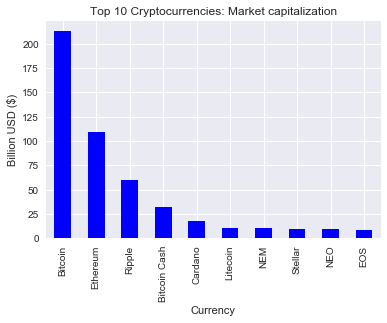

Total market capitalization of cryptocurrencies: $ 613.96 billion


In [5]:
_ = (market_cap[:10]/1000000000).plot.bar(color='blue', legend=False)
_ = plt.title('Top 10 Cryptocurrencies: Market capitalization')
_ = plt.xlabel('Currency')
_ = plt.ylabel('Billion USD ($)')
plt.show()

total_cap = np.sum(market_cap)
print('Total market capitalization of cryptocurrencies: $', round(total_cap[0]/1000000000,2), 'billion')

We can see that the total capitalization of cryptocurrencies is already huge, Bitcoin is the biggest player on the market, followed by Ethereum and Ripple. 

## Some more data

The following dataset is downloaded from [Kaggle](https://www.kaggle.com/jessevent/all-crypto-currencies/data), a platform that hosts data-related competitions. This dataset includes daily price data from 2013 onwards, for all cryptocurrencies. 

In [6]:
# Importing the data
df1 = pd.read_csv('crypto-markets.csv')

# Data inspection
df1.head(5)

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0,1500520000,0.5438,3.88
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0,1491160000,0.7813,13.49
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0,1597780000,0.3843,12.88
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0,1542820000,0.2882,32.17
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0,1292190000,0.3881,33.32


In [7]:
# Selecting data as of 2017
df1['date'] = pd.to_datetime(df1['date'])
df1 = df1.loc[df1['date'] >= '2017']

# Selecting relevant columns
exchange = df1[['symbol','name','close','date']]

# Selecting relevant currencies
exchange.dropna(inplace = True)

exchangeBTC = exchange.loc[exchange['symbol'] == 'BTC'] 
exchangeETH = exchange.loc[exchange['symbol'] == 'ETH'] 
exchangeRIP = exchange.loc[exchange['symbol'] == 'XRP'] 

exchange = pd.concat([exchangeBTC, exchangeETH, exchangeRIP], ignore_index=True)

# Order by date
exchange.sort_values(['date','symbol'], inplace=True)

# Setting the index
exchange.set_index('date', inplace=True)

In [8]:
# Constructing new columns from the closing prices
exchange['Bitcoin'] = exchange.close[0::3]
exchange['Ethereum'] = exchange.close[1::3]
exchange['Ripple'] = exchange.close[2::3]

# Keeping only the relevant columns and dropping duplicate rows
exchange = exchange[['Bitcoin','Ethereum','Ripple']]
exchange = exchange.loc[::3,:]

# Inspecting the dataframe
exchange.head()

,Bitcoin,Ethereum,Ripple
date,,,
2017-01-01,998.33,8.17,0.006368
2017-01-02,1021.75,8.38,0.006311
2017-01-03,1043.84,9.73,0.006386
2017-01-04,1154.73,11.25,0.006570
2017-01-05,1013.38,10.25,0.006201


For now, we are only interested in daily closing prices of the top three cryptocurrencies from 2017 onwards. We have altered the dataframe such that we have our three currencies as columns, dates as indeces and closing prices as values. Next, we will plot closing prices for these currencies and we will show some summary statistics for these data. 

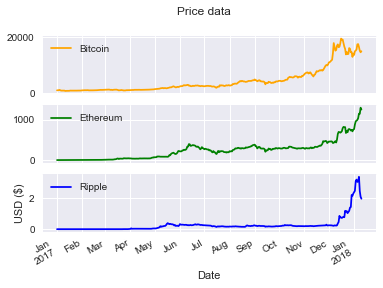

,Bitcoin,Ethereum,Ripple
count,375.000000,375.000000,375.000000
mean,4314.172480,245.937333,0.270975
std,4415.960737,228.729135,0.495798
min,777.760000,8.170000,0.005408
25%,1197.140000,48.260000,0.031331
50%,2608.720000,251.700000,0.197339
75%,4777.005000,317.300000,0.251758
max,19497.400000,1299.740000,3.380000


In [9]:
COLORS = ['orange','green','blue']

_ = exchange.plot.line(title = 'Price data', subplots = True, color=COLORS)
_ = plt.xlabel('Date')
_ = plt.ylabel('USD ($)')
plt.show()

exchange.describe()

As can be seen, Bitcoin prices have always been far ahead, the currencies seem to have become more correlated and Ripple has only begun showing a massive price increase in the recent past. 

As a benchmark we will now load data from the Yahoo Finance API for the S&P 500, we will again select closing prices using the same dates. The S&P 500 is often used as a proxy for the performance of the USA stock market.  

In [10]:
# We will compare these returns against the S&P 500
start = date(2017, 1, 1)
end = date(2018, 1, 10)
ticker = '^GSPC'
data_source = 'yahoo'
stock_data = DataReader(ticker, data_source, start, end)

sp500 = pd.DataFrame(stock_data.Close)

# Data inspection
sp500.head()

,Close
Date,
2017-01-03,2257.830078
2017-01-04,2270.750000
2017-01-05,2269.000000
2017-01-06,2276.979980
2017-01-09,2268.899902


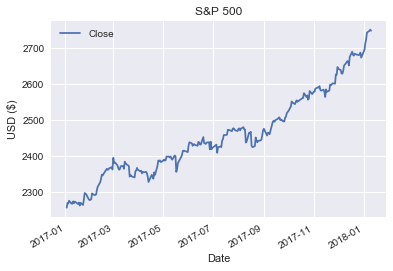

,Close
count,258.000000
mean,2456.749656
std,117.371874
min,2257.830078
25%,2367.520081
50%,2438.255005
75%,2550.312439
max,2751.290039


In [11]:
_ = sp500.plot.line(title='S&P 500')
_ = plt.ylabel('USD ($)')
plt.show()

sp500.describe()

As can be seen in the plot above, the S&P 500 has shown some steady progress in 2017 as well. However, while not clearly visible from this graph, the S&P 500 is trumped by cryptocurrencies in terms of performance over 2017. 

Let us now add the S&P 500 data to our cryptocurrency data, 

In [12]:
exchange['SP500'] = sp500.Close
exchange.dropna(inplace=True) #to be able to substract SP500 (closed on weekends)
exchange.head()

,Bitcoin,Ethereum,Ripple,SP500
date,,,,
2017-01-03,1043.84,9.73,0.006386,2257.830078
2017-01-04,1154.73,11.25,0.006570,2270.750000
2017-01-05,1013.38,10.25,0.006201,2269.000000
2017-01-06,902.20,10.25,0.006315,2276.979980
2017-01-09,902.83,10.33,0.006167,2268.899902


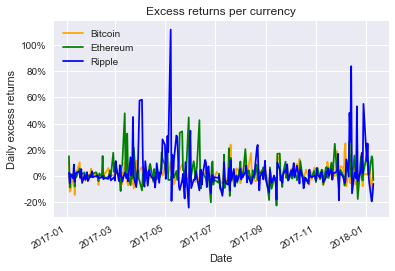

In [13]:
# Showing the daily risk premium of the three different currencies

daily_returns = exchange.pct_change()
crypto_returns = daily_returns[['Bitcoin','Ethereum','Ripple']]
sp_returns = daily_returns['SP500']
excess_returns = crypto_returns.sub(sp_returns, axis=0)

_ = excess_returns.plot(title = 'Excess returns per currency', color=COLORS)
_.yaxis.set_major_formatter(FuncFormatter(lambda y, _:'{:.0%}'.format(y)))
_ = plt.ylabel('Daily excess returns')
_ = plt.xlabel('Date')
plt.show()


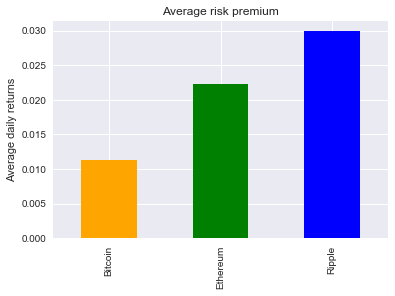

In [14]:
# The mean of the excess returns
avg_excess_returns = excess_returns.mean()

# Plotting the means of the return differences
_ = avg_excess_returns.plot.bar(title = 'Average risk premium', color=COLORS)
_ = plt.ylabel('Average daily returns')
plt.show()


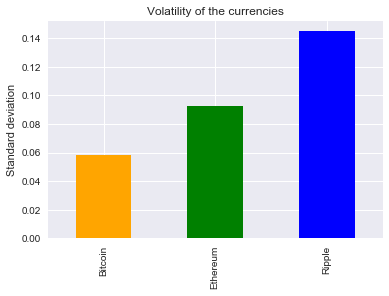

In [15]:
# The standard deviation of the excess returns
std_excess_returns = excess_returns.std()

# Plotting the standard devations of the return differences
_ = std_excess_returns.plot.bar(title = 'Volatility of the currencies', color=COLORS)
_ = plt.ylabel('Standard deviation')
plt.show()

In [16]:
# We define a function for the annualized Sharpe ratio
def sharpe(mean, std, n_periods):
    return np.sqrt(n_periods)*(mean/std)

# Now we calculate the sharpe ratio for the three cryptocurrencies
pd.DataFrame(sharpe(avg_excess_returns, std_excess_returns, len(excess_returns)),columns=["Annualized Sharpe Ratio"])

,Annualized Sharpe Ratio
Bitcoin,3.117520
Ethereum,3.849850
Ripple,3.313994


## Result

In [17]:
print('Based on the Sharpe ratios of these results, it seems best to buy', np.argmax(sharpe(avg_excess_returns, std_excess_returns, len(excess_returns))))

Based on the Sharpe ratios of these results, it seems best to buy Ethereum


## Part 2

In [18]:
rates = df1[['date','name','close']]
rates = rates.pivot_table(index='date',columns='name', values='close', aggfunc='mean')
rates.head()

name,0x,10M Token,1337,2GIVE,300 Token,42-coin,808Coin,8Bit,9COIN,AI Doctor,...,iDice,iEthereum,iExec RLC,iQuant,iTicoin,iXledger,netBit,onG.social,vSlice,vTorrent
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,NaN,NaN,0.000001,0.000330,NaN,NaN,0.000190,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000502,NaN,0.081857,0.025942
2017-01-02,NaN,NaN,0.000002,0.000276,NaN,NaN,0.000163,0.011243,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000451,NaN,0.077368,0.021693
2017-01-03,NaN,NaN,0.000002,0.000380,NaN,NaN,0.000167,0.012373,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000450,NaN,0.062777,0.022364
2017-01-04,NaN,NaN,0.000001,0.000392,NaN,NaN,0.000185,0.013417,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000600,NaN,0.057517,0.025055
2017-01-05,NaN,NaN,0.000001,0.000263,NaN,NaN,0.000101,0.010844,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.055768,0.022355


In [19]:
avg_daily_return = rates.pct_change().mean()
std_daily_return = rates.pct_change().std()

avg_daily_return = pd.DataFrame(avg_daily_return).reset_index()
avg_daily_return.columns = ['name', 'avg']

std_daily_return = pd.DataFrame(std_daily_return).reset_index()
std_daily_return.columns = ['-', 'std']

avg_std_dr = pd.concat([avg_daily_return,std_daily_return], axis=1)
avg_std_dr = avg_std_dr[['name','avg','std']]
avg_std_dr.head()

,name,avg,std
0,0x,0.021216,0.113665
1,10M Token,0.165021,0.729515
2,1337,0.134956,0.742289
3,2GIVE,0.022978,0.155210
4,300 Token,0.021922,0.220645


In [20]:
avg_std_BER = avg_std_dr.loc[(avg_std_dr.name == 'Bitcoin')|(avg_std_dr.name == 'Ethereum')|(avg_std_dr.name == 'Ripple')]
avg_std_BER['colors'] = COLORS
avg_std_BER.head()

,name,avg,std,colors
150,Bitcoin,0.008508,0.050284,orange
461,Ethereum,0.016086,0.073026,green
1031,Ripple,0.022783,0.143775,blue


In [30]:
# Let us make an interactive plot using Bokeh
#output_notebook
source = ColumnDataSource(avg_std_dr)
p = figure(y_axis_label='Average daily return', x_axis_label='Std. dev. of daily returns', y_range=(-0.05,0.2), x_range=(0,1), title='avg/std relations for each cryptocurrency')
p.circle(y='avg', x='std', source=source, size=5)

source1 = ColumnDataSource(avg_std_BER)
p.inverted_triangle(y='avg', x='std', source=source1, size=15, fill_color='colors', line_color='black')

hover = HoverTool(tooltips=[('Currency','@name')])
p.add_tools(hover)
show(p)

slope = 0.13692
intercept = 0.00680


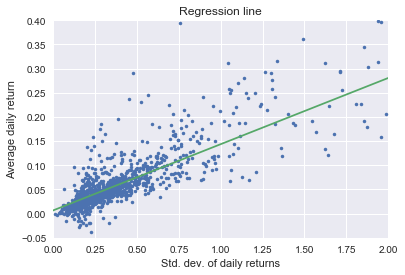

In [22]:
# Getting rid of some outliers
avg_std_dr = avg_std_dr[avg_std_dr['avg']<0.5]
avg_std_dr = avg_std_dr[avg_std_dr['std']<4]

# How is the average related to the standard deviation?
_ = plt.plot(avg_std_dr['std'], avg_std_dr['avg'], marker='.', linestyle='none')
_ = plt.ylim(-0.05,0.4)
_ = plt.xlim(0,2)
_ = plt.ylabel('Average daily return')
_ = plt.xlabel('Std. dev. of daily returns')
_ = plt.title('Regression line')

a, b = np.polyfit(avg_std_dr['std'], avg_std_dr['avg'],1)

print('slope = %.5f'% a)
print('intercept = %.5f'% b)

x = np.array([-1,4])
y = a * x + b

_ = plt.plot(x,y)
plt.show()

In [23]:
# Let us try to predict Bitcoin prices
bit = df1[df1.symbol == 'BTC'].drop(['ranknow','close_ratio','slug','symbol','name'], axis=1)
bit['HL_PCT'] = 100*(bit.high - bit.low) / bit.low
bit['CO_PCT'] = 100*(bit.close - bit.open) / bit.open
bit = bit.set_index('date')
bit = bit[['close','HL_PCT','CO_PCT','volume']]

# Chosing 20 days as number of forecast days
forecast_out = int(20)
bit['label'] = bit['close'].shift(-forecast_out)

# We now have 20 days of missing labels 
bit.tail()

,close,HL_PCT,CO_PCT,volume,label
date,,,,,
2018-01-06,17527.0,5.653580,0.371662,18314600000,NaN
2018-01-07,16477.6,9.273544,-5.988943,15866000000,NaN
2018-01-08,15170.1,16.396869,-7.927192,18413900000,NaN
2018-01-09,14595.4,7.442457,-3.493193,16660000000,NaN
2018-01-10,14973.3,9.364409,2.637694,18500800000,NaN


In [24]:
# We define a matrix of features
X = np.array(bit.drop(['label'], 1))

# Center to the mean and component wise scale to unit variance
X = scale(X)

# Split the rows for which we do not have label data
X_forecast_out = X[-forecast_out:]
X = X[:-forecast_out]

# Define label vector
y = np.array(bit['label'])
y = y[:-forecast_out]

# Check whether X and y are equal in lenght (if this is not the case we get an error)
assert(len(X)==len(y))

In [25]:
# We split the data into training and test data
# test_size = 0.2 ==> 20% data is test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

# We fit the model to the training data and test it on the test data
clf = LinearRegression()
clf.fit(X_train,y_train)

accuracy = clf.score(X_test, y_test)
print("Accuracy of Linear Regression: ", accuracy)

Accuracy of Linear Regression:  0.8280022675087291


The model did reasonably well in predicting the test data, let us now attempt to predict 30 days into the future  

In [113]:
forecast_prediction = clf.predict(X_forecast_out)

print(forecast_prediction)

last_date = bit.iloc[-1].name

forecast = pd.DataFrame(forecast_prediction)
forecast['date'] = pd.date_range(last_date + timedelta(days=1) , periods=forecast_out, freq='D')
forecast.set_index(['date'], inplace=True)

forecast['BTC Prediction'] = forecast.loc[:,0]
forecast = forecast[['BTC Prediction']]

# Prevent the plot to have a discontinuity
last_entry = pd.DataFrame(bit.close.iloc[-1], columns=['BTC Prediction'], index=[bit.iloc[-1].name])
forecast = last_entry.append(forecast)

[ 9530.89891635 15305.13006879 15101.18992668 15474.99332167
 17567.52210993 17378.92780518 15638.01943166 14900.60234153
 12015.23086862 15053.1226527  15042.6178335  13707.26979803
 13275.59358774 11072.88180844 13177.35316353 16061.06083437
 16117.34312275 12908.67135648 12587.71679704 12179.04261833]


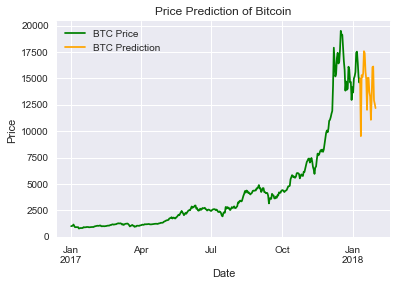

In [114]:
ax = bit['close'].plot(color="green", label='BTC Price')
forecast.plot(color="orange", label='BTC Prediction', ax=ax)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Prediction of Bitcoin')
plt.show()


Note that this model does not know whether Bitcoin is a bubble, it therefore predicts the future only knowing the past prices and not knowing about anything else. The model will therefore predict the prices of Bitcoin to explode in the future as it did in the past, it is very likely that this is an unrealistic scenario. 

Accuracy of Linear Regression:  0.8635668927125218


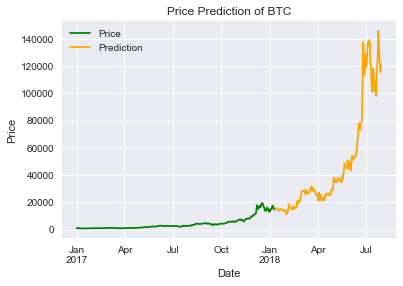

In [115]:
# Let us define a function which outputs the graph shown above for a given number of future periods
def plot_future(n, coin):
    # Let us try to predict Bitcoin prices
    bit = df1[df1.symbol == coin].drop(['ranknow','close_ratio','slug','symbol','name'], axis=1)
    bit['HL_PCT'] = 100*(bit.high - bit.low) / bit.low
    bit['CO_PCT'] = 100*(bit.close - bit.open) / bit.open
    bit = bit.set_index('date')
    bit = bit[['close','HL_PCT','CO_PCT','volume']]
    
    # Chosing n days as number of forecast days
    forecast_out = int(n)
    bit['label'] = bit['close'].shift(-forecast_out)
    
    # We now have n days of missing labels 
    # We define a matrix of features
    X = np.array(bit.drop(['label'], 1))
    
    # Center to the mean and component wise scale to unit variance
    X = scale(X)
    
    # Split the rows for which we do not have label data
    X_forecast_out = X[-forecast_out:]
    X = X[:-forecast_out]
    
    # Define label vector
    y = np.array(bit['label'])
    y = y[:-forecast_out]
    
    # Check whether X and y are equal in lenght (if this is not the case we get an error)
    assert(len(X)==len(y))
    
    # We split the data into training and test data
    # test_size = 0.2 ==> 20% data is test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
    
    # We fit the model to the training data and test it on the test data
    clf = LinearRegression()
    clf.fit(X_train,y_train)
    
    accuracy = clf.score(X_test, y_test)
    print("Accuracy of Linear Regression: ", accuracy)
    forecast_prediction = clf.predict(X_forecast_out)

    last_date = bit.iloc[-1].name
    
    forecast = pd.DataFrame(forecast_prediction)
    forecast['date'] = pd.date_range(last_date + timedelta(days=1) , periods=forecast_out, freq='D')
    forecast.set_index(['date'], inplace=True)
    
    forecast['Prediction'] = forecast.loc[:,0]
    forecast = forecast[['Prediction']]
    
    # Prevent the plot to have a discontinuity
    last_entry = pd.DataFrame(bit.close.iloc[-1], columns=['Prediction'], index=[bit.iloc[-1].name])
    forecast = last_entry.append(forecast)
    
    ax = bit['close'].plot(color="green", label='Price')
    forecast.plot(color="orange", label='Prediction', ax=ax)
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Price Prediction of '+coin)
    plt.show()

# Let us show what the model predicts 200 days into the future
    
plot_future(200, 'BTC')

As can be seen above, the model predicts BTC prices to explode. Let us plot another currency.

Accuracy of Linear Regression:  0.019419242446489737


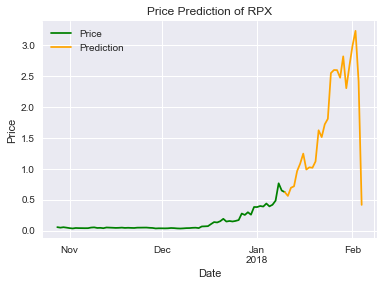

In [130]:
plot_future(25,'RPX')

Ripple seems to crash at the end of January... (Pretty inaccurate though)